# Time Series Forecasting Project using ARIMA model 
## 1. Import Modules 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

## 2. Data download and inspection

In [2]:
raw_data_df=sns.load_dataset("flights")
raw_data_df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


### 2.1. Inspection 

In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [4]:
raw_data_df.head().T

,0,1,2,3,4
year,1949,1949,1949,1949,1949
month,Jan,Feb,Mar,Apr,May
passengers,112,118,132,129,121


In [5]:
raw_data_df.describe()

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


### 2.2. Encode 'Month' and 'Year' features 

In [6]:
timeseries_df=raw_data_df.copy()
   
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month   
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))
timeseries_df=timeseries_df.set_index('date')
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [7]:
timeseries_df.head()

,dependent_var
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 3. EDA
### 3.1 Baseline Model performance 
#### 3.1.1 Linear Regression Model Baseline 

In [8]:
linear_model=LinearRegression()
x=np.array(range(len(timeseries_df))).reshape(-1, 1)
fit_result=linear_model.fit(x, timeseries_df['dependent_var'])
predictions=linear_model.predict(x)
timeseries_df['Linear model']=predictions
rmse=sqrt(mean_squared_error(timeseries_df['dependent_var'], predictions))
print(f'Linear model root mean square error: {rmse:.1f}')

Linear model root mean square error: 45.7


#### 3.1.2 'Carry forward' baseline 

In [9]:
predictions=timeseries_df['dependent_var'].to_numpy()[1:]
true_values=timeseries_df['dependent_var'].to_numpy()[0:-1]
rmse=sqrt(mean_squared_error(true_values, predictions))
print(f'Carry forward model root mean square error: {rmse:.1f}')

Carry forward model root mean square error: 33.7


### 3.2 Handle missing / extreme values 

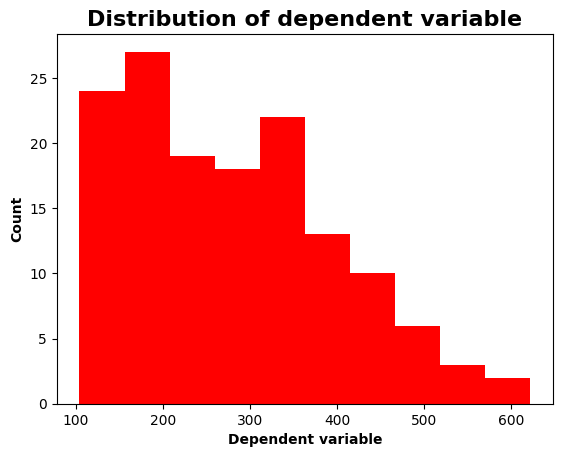

In [10]:
plt.title('Distribution of dependent variable', fontsize=16, fontweight='bold')
plt.hist(timeseries_df['dependent_var'], color='red', bins=10)
plt.xlabel('Dependent variable', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.show()

In [11]:
timeseries_df.head(12)

,dependent_var,Linear model
date,,
1949-01-01,112,90.309962
1949-02-01,118,92.967146
1949-03-01,132,95.624330
1949-04-01,129,98.281513
1949-05-01,121,100.938697
1949-06-01,135,103.595881
1949-07-01,148,106.253065
1949-08-01,148,108.910249
1949-09-01,136,111.567433


In [12]:
timeseries_df.describe()

,dependent_var,Linear model
count,144.000000,144.000000
mean,280.298611,280.298611
std,119.966317,110.839929
min,104.000000,90.309962
25%,180.000000,185.304286
50%,265.500000,280.298611
75%,360.500000,375.292936
max,622.000000,470.287261


#### 3.2.1 Time-series plot 

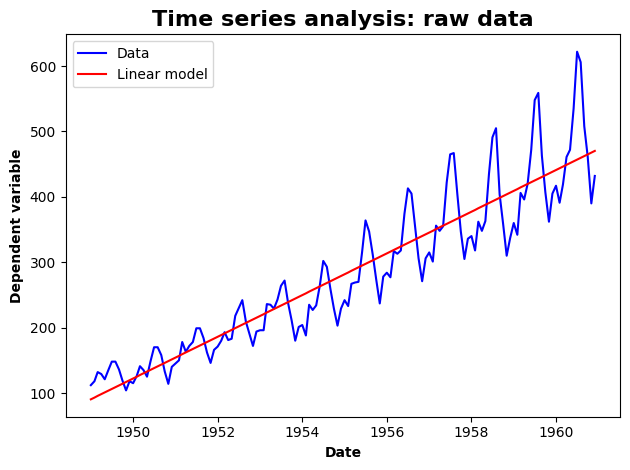

In [13]:
plt.title('Time series analysis: raw data', fontsize=16, fontweight='bold')
plt.plot(timeseries_df['dependent_var'], label='Data', color='blue')
plt.plot(timeseries_df['Linear model'], label='Linear model', color='red')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Dependent variable', fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### 3.2.2 Missing timepoints 

Datetime axis is regular: False

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   Linear model   144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


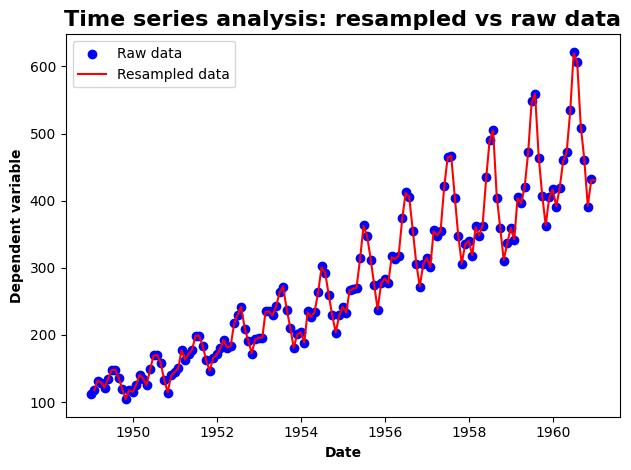

In [14]:
diff=np.diff(timeseries_df.index.to_numpy())
equally_spaced=np.all(diff==diff[0])
print(f'Datetime axis is regular: {equally_spaced}\n')

if equally_spaced == False:
    resampled_timeseries_df=timeseries_df.resample('D').interpolate()
    resampled_timeseries_df=resampled_timeseries_df.resample('ME').interpolate()
    resampled_timeseries_df.info()

    plt.title('Time series analysis: resampled vs raw data', fontsize=16, fontweight='bold')
    plt.scatter(timeseries_df.index, timeseries_df['dependent_var'], label='Raw data', color='blue')
    plt.plot(resampled_timeseries_df.index, resampled_timeseries_df['dependent_var'], label='Resampled data', color='red')
    plt.xlabel('Date', fontweight='bold')
    plt.ylabel('Dependent variable', fontweight='bold')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    timeseries_df=resampled_timeseries_df

In [15]:
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   Linear model   144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


In [16]:
timeseries_df.head(12)

,dependent_var,Linear model
date,,
1949-01-31,117.806452,92.881430
1949-02-28,131.500000,95.529430
1949-03-31,129.096774,98.195798
1949-04-30,121.266667,100.850125
1949-05-31,134.548387,103.510166
1949-06-30,147.566667,106.164492
1949-07-31,148.000000,108.824533
1949-08-31,136.387097,111.481717
1949-09-30,119.566667,114.136044


#### 3.2.3 Stationarity 

In [17]:
dftest=adfuller(timeseries_df['dependent_var'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.984


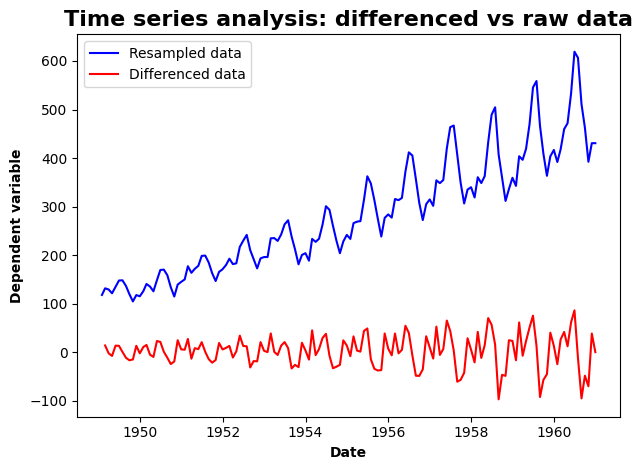

In [18]:
stationary_timeseries_df=timeseries_df['dependent_var'].diff().dropna()

plt.title('Time series analysis: differenced vs raw data', fontsize=16, fontweight='bold')
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Resampled data', color='blue')
plt.plot(stationary_timeseries_df.index, stationary_timeseries_df, label='Differenced data', color='red')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Dependent variable', fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 4. Model training 

In [19]:
timeseries_model=auto_arima(timeseries_df['dependent_var'], seasonal=True, stationary=False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1012.628, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1021.005, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1012.917, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1013.833, Time=0.13 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1012.119, Time=0.68 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1011.298, Time=0.34 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1011.809, Time=0.68 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1016.507, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1016.547, Time=0.09 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(2,1,3)(0,1,0)[12]             : AIC=1012.999, Time=0.31 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1014.559, Time=0.13 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=1010.846, Time=0.98 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=1010.976, Time=0.92 sec
 ARIMA(1,1,3)(0,1,1)[12]

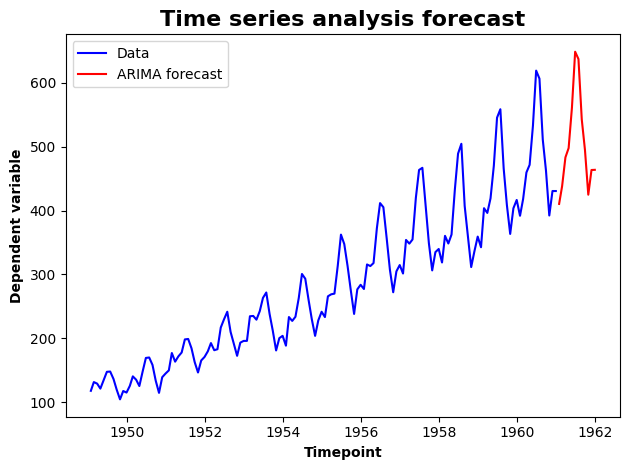

In [20]:
forecast=timeseries_model.predict(12)

plt.title('Time series analysis forecast', fontsize=16, fontweight='bold')
plt.plot(timeseries_df['dependent_var'], label='Data', color='blue')
plt.plot(forecast, label='ARIMA forecast', color='red')
plt.xlabel('Timepoint', fontweight='bold')
plt.ylabel('Dependent variable', fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

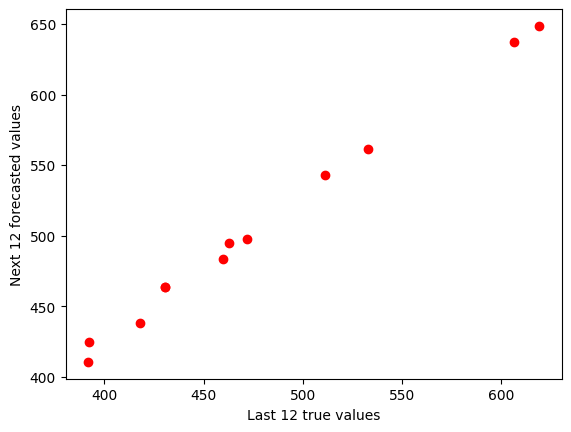

In [21]:
true_data=timeseries_df['dependent_var'][-12:]

plt.scatter(true_data, forecast, color='red')
plt.xlabel('Last 12 true values')
plt.ylabel('Next 12 forecasted values')
plt.show()

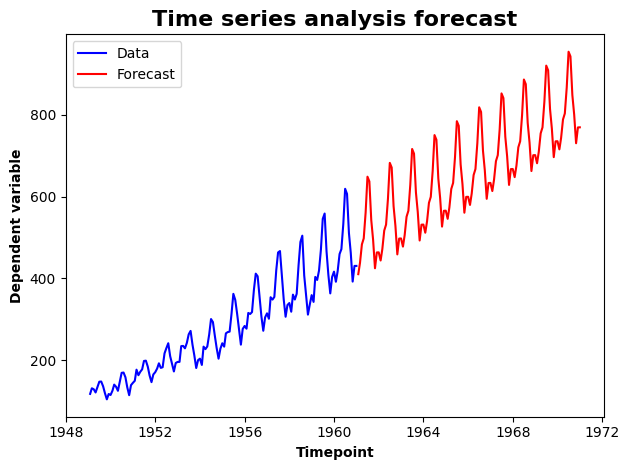

In [22]:
forecast=timeseries_model.predict(120)

plt.title('Time series analysis forecast', fontsize=16, fontweight='bold')
plt.plot(timeseries_df['dependent_var'], label='Data', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Timepoint', fontweight='bold')
plt.ylabel('Dependent variable', fontweight='bold')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- Looks like model is repeating the trend of the last year time series! 

## 5. Model Evaluation 

### 5.1 Train-Test split 

In [24]:
forecast_horizon=6
model_order=36

testing_dataset_size=forecast_horizon
training_set_size=len(timeseries_df) - testing_dataset_size
training_data=timeseries_df[:training_set_size]
testing_data=timeseries_df[training_set_size:]

### 5.2 Cross-validation 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=175.688, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=178.796, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=171.344, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=175.555, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=251.740, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=170.231, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=171.392, Time=0.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=173.268, Time=0.31 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=171.868, Time=0.17 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=171.995, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=173.796, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=173.827, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=176.232, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 1.943 seconds
Performing stepwise s

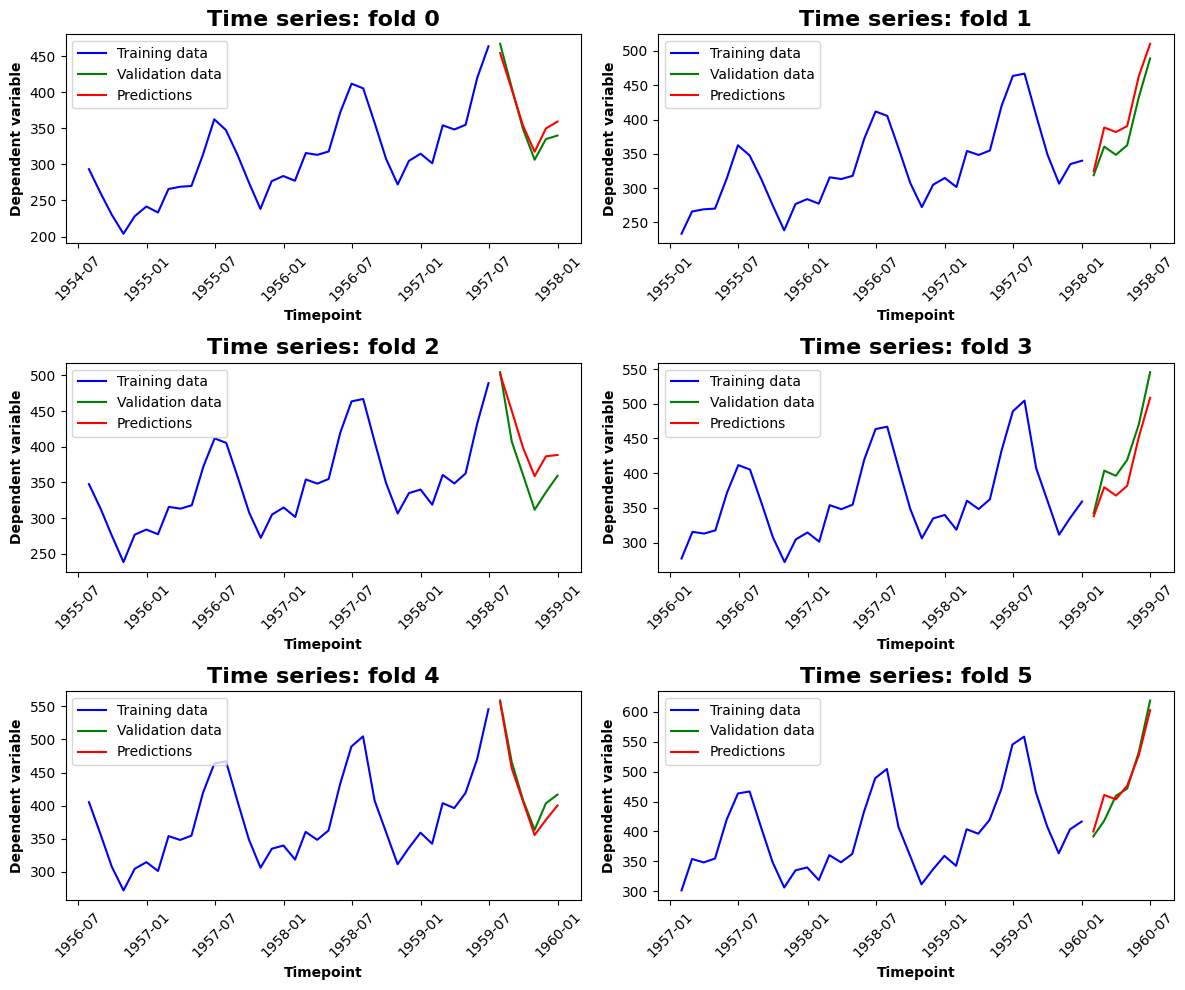

In [25]:
folds=6

validation_rmse_values=[]
predicted_values=[]
validation_values=[]

fig, axs=plt.subplots(3, 2, figsize=(12,10))
axs=axs.flatten()

timeseries_splits=TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

for i, timeseries_split in enumerate(timeseries_splits.split(training_data)):
    training_indices=timeseries_split[0]
    validation_indices=timeseries_split[1]

    fold_training_data=training_data.iloc[training_indices, :]
    fold_validation_data=training_data.iloc[validation_indices, :]

    timeseries_model=auto_arima(fold_training_data['dependent_var'], stationary=False, trace=True, seasonal=True, m=12, suppress_warnings=True)
    forecast=timeseries_model.predict(forecast_horizon)

    predicted_values.extend(forecast)
    validation_values.extend(fold_validation_data['dependent_var'])

    rmse=sqrt(mean_squared_error(fold_validation_data['dependent_var'], forecast))
    validation_rmse_values.append(rmse)

    axs[i].set_title(f'Time series: fold {i}', fontsize=16, fontweight='bold')
    axs[i].plot(fold_training_data['dependent_var'], label='Training data', color='blue')
    axs[i].plot(fold_validation_data['dependent_var'], label='Validation data', color='green')
    axs[i].plot(forecast, label='Predictions', color='red')
    axs[i].set_xlabel('Timepoint', fontweight='bold')
    axs[i].set_ylabel('Dependent variable', fontweight='bold')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()

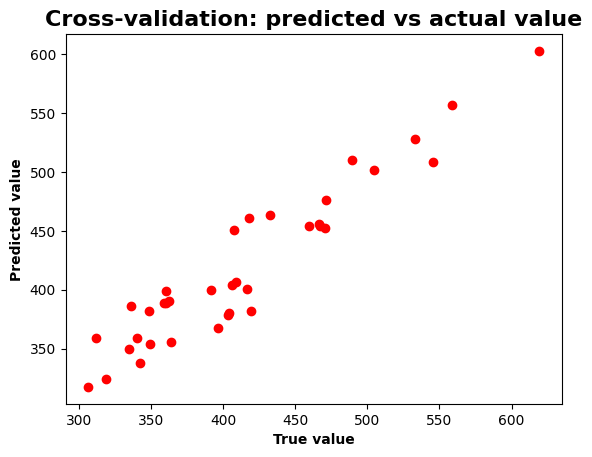

In [28]:
plt.title('Cross-validation: predicted vs actual value', fontsize=16, fontweight='bold')
plt.scatter(validation_values, predicted_values, color='red')
plt.xlabel('True value', fontweight='bold')
plt.ylabel('Predicted value', fontweight='bold')
plt.show()

In [29]:
print(f'Cross-validation RMSE: {np.mean(validation_rmse_values):.1f}+/-{np.std(validation_rmse_values):.1f}')

Cross-validation RMSE: 22.8+/-9.1


### 5.3 Linear model test set performance 

In [30]:
linear_model=LinearRegression()
x=np.array(range(len(training_data))).reshape(-1, 1)
fit_result=linear_model.fit(x, training_data['dependent_var'])
x_test=np.array(range(len(training_data),len(training_data) + forecast_horizon)).reshape(-1, 1)
predictions=linear_model.predict(x_test)
rmse=sqrt(mean_squared_error(testing_data['dependent_var'], predictions))
rmse_results={'Linear model': rmse}
print(f'Linear model root mean square error: {rmse:.1f}')

Linear model root mean square error: 74.3


### 5.4 Carry forward model test set performance 

In [31]:
predictions=testing_data['dependent_var'].to_numpy()[1:]
true_values=testing_data['dependent_var'].to_numpy()[0:-1]
rmse=sqrt(mean_squared_error(true_values, predictions))
rmse_results['Cary forward model']=rmse
print(f'Carry forward model root mean square error: {rmse:.1f}')

Carry forward model root mean square error: 59.8


### 5.5 ARIMA model test set performance 

In [32]:
timeseries_model=auto_arima(training_data['dependent_var'], stationary=False, seasonal=True, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=969.238, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=961.838, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=962.689, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=961.254, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=962.205, Time=0.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=963.026, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=962.740, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=961.930, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=964.709, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=962.832, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 3.783 seconds


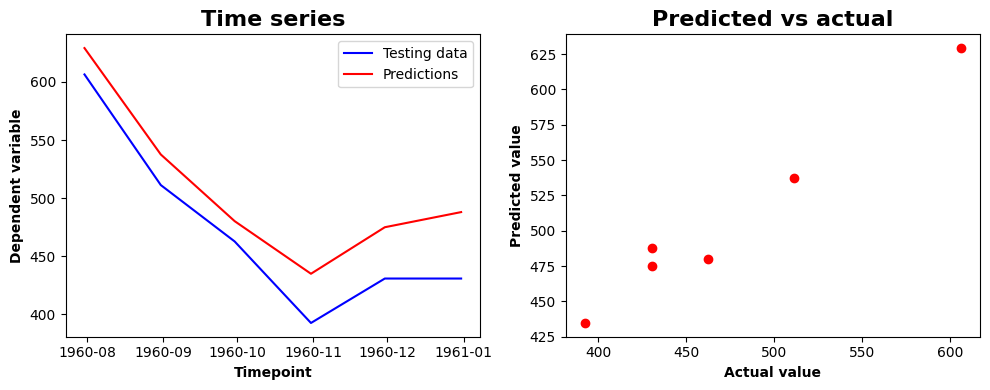

In [35]:
forecast=timeseries_model.predict(forecast_horizon)

# Plot the result
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,4))

ax1.set_title('Time series', fontsize=16, fontweight='bold')
ax1.plot(testing_data['dependent_var'], label='Testing data', color='blue')
ax1.plot(forecast, label='Predictions', color='red')
ax1.set_xlabel('Timepoint', fontweight='bold')
ax1.set_ylabel('Dependent variable', fontweight='bold')
ax1.legend(loc='best')

ax2.set_title('Predicted vs actual', fontsize=16, fontweight='bold')
ax2.scatter(testing_data['dependent_var'], forecast, color='red')
ax2.set_xlabel('Actual value', fontweight='bold')
ax2.set_ylabel('Predicted value', fontweight='bold')

plt.tight_layout()
plt.show()

In [36]:
# Calculate RMSE on test set
rmse=sqrt(mean_squared_error(testing_data['dependent_var'], forecast))
rmse_results['ARIMA test data']=rmse

print(f'Root mean square error:')

for experiment, rmse in rmse_results.items():
    print(f'  {experiment}: {rmse:.1f}')

Root mean square error:
  Linear model: 74.3
  Cary forward model: 59.8
  ARIMA test data: 37.8
